In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score

In [32]:

df = pd.read_csv('StudentsPerformance.csv')

X = df.drop('math score', axis=1)
y = df['math score']

categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

In [33]:
# 5. & 6. Handle Missing Values & Feature Scaling & Encoding
# Pipeline for numerical data: Impute missing with mean + Scale
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Pipeline for categorical data: Impute missing + OneHotEncode
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])


In [34]:
# 7. Split Dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply preprocessing
X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc = preprocessor.transform(X_test)

# Extract feature names for interpretation
ohe_feature_names = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_cols)
all_feature_names = numerical_cols + list(ohe_feature_names)

# 8. & 9. Train and Predict (Multilinear Regression)
lr_model = LinearRegression()
lr_model.fit(X_train_proc, y_train)
y_pred = lr_model.predict(X_test_proc)

# 10. Evaluate Performance
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"--- Linear Regression Performance ---")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2 Score: {r2:.2f}\n")

--- Linear Regression Performance ---
MSE: 29.10
RMSE: 5.39
R2 Score: 0.88



In [35]:
# 11. Analyze Regression Coefficients
coefficients = pd.DataFrame({'Feature': all_feature_names, 'Coefficient': lr_model.coef_})
print("Top 5 Influential Features:")
print(coefficients.sort_values(by='Coefficient', ascending=False).head(5))

Top 5 Influential Features:
                   Feature  Coefficient
1            writing score    10.917190
3              gender_male     6.532442
8   race/ethnicity_group E     4.090025
0            reading score     3.411114
16          lunch_standard     1.755037


In [36]:

# 12. Optimize the Model (Ridge and Lasso)
ridge = Ridge(alpha=1.0).fit(X_train_proc, y_train)
lasso = Lasso(alpha=0.1).fit(X_train_proc, y_train)

print(f"\nRidge R2 Score: {ridge.score(X_test_proc, y_test):.2f}")
print(f"Lasso R2 Score: {lasso.score(X_test_proc, y_test):.2f}")



Ridge R2 Score: 0.88
Lasso R2 Score: 0.88


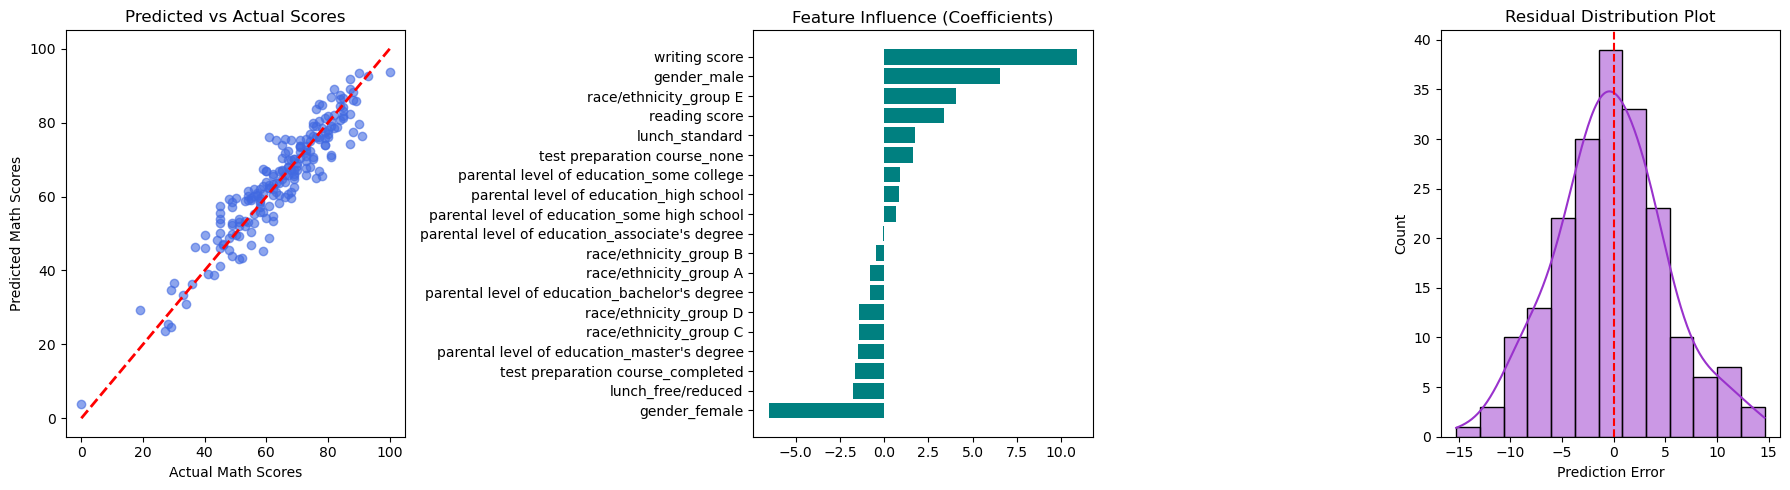

In [37]:

plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.scatter(y_test, y_pred, alpha=0.6, color='royalblue')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.xlabel('Actual Math Scores')
plt.ylabel('Predicted Math Scores')
plt.title('Predicted vs Actual Scores')

# Visualization 2: Coefficient Magnitude
plt.subplot(1, 3, 2)
coef_plot = coefficients.sort_values(by='Coefficient', ascending=True)
plt.barh(coef_plot['Feature'], coef_plot['Coefficient'], color='teal')
plt.title('Feature Influence (Coefficients)')

# Visualization 3: Residual Distribution
plt.subplot(1, 3, 3)
residuals = y_test - y_pred
sns.histplot(residuals, kde=True, color='darkorchid')
plt.axvline(x=0, color='red', linestyle='--')
plt.title('Residual Distribution Plot')
plt.xlabel('Prediction Error')

plt.tight_layout()
plt.show()


In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [39]:

df = pd.read_csv('auto-mpg.csv')

df['horsepower'] = pd.to_numeric(df['horsepower'], errors='coerce')

# Drop rows with missing values (NaN) created by the conversion
df = df.dropna(subset=['horsepower', 'mpg'])

# Define features (X) and target (y)
X = df[['horsepower']].values
y = df['mpg'].values

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [41]:
# Create polynomial features of degree 2 (Quadratic)
poly_transformer = PolynomialFeatures(degree=2)
X_train_poly = poly_transformer.fit_transform(X_train)
X_test_poly = poly_transformer.transform(X_test)

In [42]:
model = LinearRegression()
model.fit(X_train_poly, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [43]:
# Predict on the test set
y_pred = model.predict(X_test_poly)

# Metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R-squared Score: {r2:.4f}")


Mean Squared Error: 18.42
R-squared Score: 0.6392


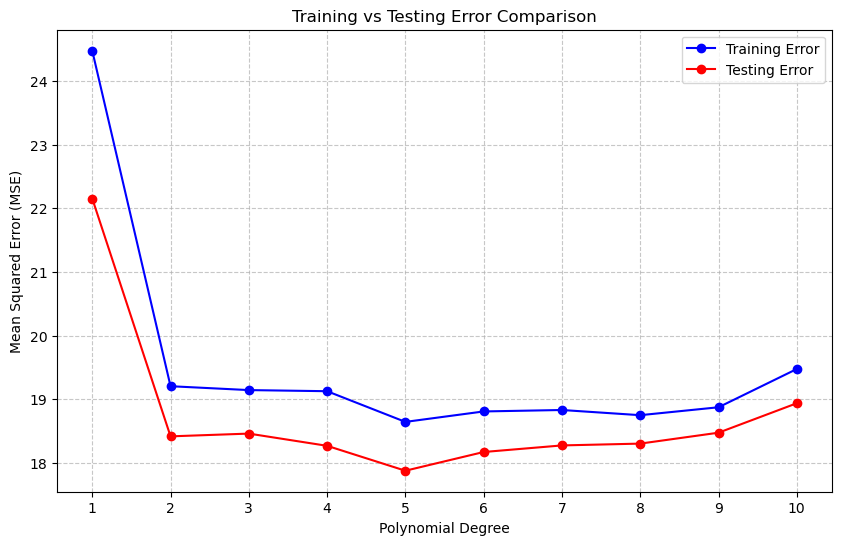

In [45]:
train_errors = []
test_errors = []
degrees_list = range(1, 11)

for deg in degrees_list:
    poly = PolynomialFeatures(degree=deg)
    X_poly_train = poly.fit_transform(X_train)
    X_poly_test = poly.transform(X_test)
    
    model = LinearRegression()
    model.fit(X_poly_train, y_train)
    
    # Calculate Mean Squared Error
    train_errors.append(mean_squared_error(y_train, model.predict(X_poly_train)))
    test_errors.append(mean_squared_error(y_test, model.predict(X_poly_test)))

plt.figure(figsize=(10, 6))
plt.plot(degrees_list, train_errors, marker='o', label='Training Error', color='blue')
plt.plot(degrees_list, test_errors, marker='o', label='Testing Error', color='red')
plt.title('Training vs Testing Error Comparison')
plt.xlabel('Polynomial Degree')
plt.ylabel('Mean Squared Error (MSE)')
plt.xticks(degrees_list)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

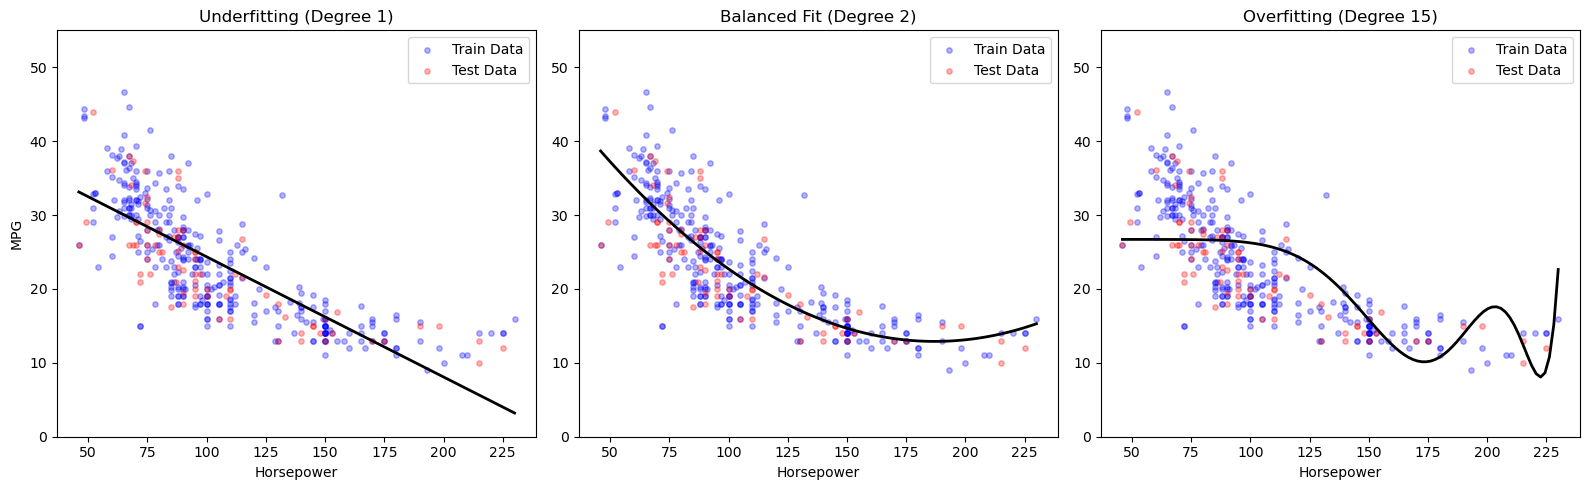

In [46]:
plt.figure(figsize=(16, 5))

# Degrees to demonstrate concepts
demo_degrees = [1, 2, 15] 
titles = ['Underfitting (Degree 1)', 'Balanced Fit (Degree 2)', 'Overfitting (Degree 15)']

for i, deg in enumerate(demo_degrees):
    plt.subplot(1, 3, i + 1)
    
    poly = PolynomialFeatures(degree=deg)
    X_poly_train = poly.fit_transform(X_train)
    
    model = LinearRegression()
    model.fit(X_poly_train, y_train)
    
    # Plot data points
    plt.scatter(X_train, y_train, color='blue', alpha=0.3, label='Train Data', s=15)
    plt.scatter(X_test, y_test, color='red', alpha=0.3, label='Test Data', s=15)
    
    # Plot regression line
    y_range_pred = model.predict(poly.transform(X_range))
    plt.plot(X_range, y_range_pred, color='black', linewidth=2)
    
    plt.title(titles[i])
    plt.xlabel('Horsepower')
    if i == 0: plt.ylabel('MPG')
    plt.ylim(0, 55)
    plt.legend()

plt.tight_layout()
plt.show()

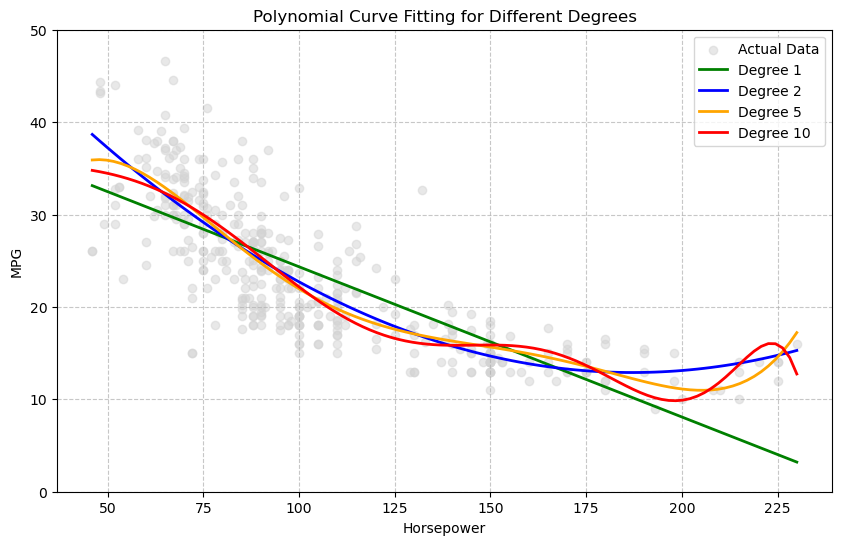

In [44]:
plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='lightgray', label='Actual Data', alpha=0.5)

degrees = [1, 2, 5, 10]
colors = ['green', 'blue', 'orange', 'red']

for deg, col in zip(degrees, colors):
    poly = PolynomialFeatures(degree=deg)
    X_poly_train = poly.fit_transform(X_train)
    
    model = LinearRegression()
    model.fit(X_poly_train, y_train)
    
    # Predict over the range for a smooth curve
    y_range_pred = model.predict(poly.transform(X_range))
    plt.plot(X_range, y_range_pred, color=col, label=f'Degree {deg}', linewidth=2)

plt.title('Polynomial Curve Fitting for Different Degrees')
plt.xlabel('Horsepower')
plt.ylabel('MPG')
plt.ylim(0, 50)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()
